In [1]:
%reload_ext autoreload

import os
import sys
import random

import torch
import numpy as np
import matplotlib.pyplot as plt

# Append python path - needed to import text_recognizer
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

/Users/niall.turbitt/opt/anaconda3/envs/text-recognizer/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

import text_recognizer.data
import text_recognizer.models

from text_recognizer.metadata.iam_paragraphs import IMAGE_HEIGHT, IMAGE_WIDTH


### IAM Paragraphs dataset

In [3]:
iam_paragraphs = text_recognizer.data.IAMParagraphs()

iam_paragraphs.prepare_data()
iam_paragraphs.setup()
x, y = next(iter(iam_paragraphs.val_dataloader()))

iam_paragraphs

IAMParagraphs.setup(None): Loading IAM paragraph regions and lines...


IAM Paragraphs Dataset
Num classes: 84
Input dims : (1, 576, 640)
Output dims: (682, 1)
Train/val/test sizes: 1087, 220, 232
Train Batch x stats: (torch.Size([128, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0221), tensor(0.0754), tensor(1.))
Train Batch y stats: (torch.Size([128, 682]), torch.int64, tensor(1), tensor(83))
Test Batch x stats: (torch.Size([128, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0278), tensor(0.0843), tensor(0.9373))
Test Batch y stats: (torch.Size([128, 682]), torch.int64, tensor(1), tensor(83))

<S>Even the bone cuff-links found beside the body, which
had at first been considered as belonging to the killer,
proved yet another red herring, for it was learned that
they had been borrowed by Elizabeth Camp from one
of her sisters. A young man from Reading named Marshall
had an uncomfortable time in the presence of the coroner.<E>


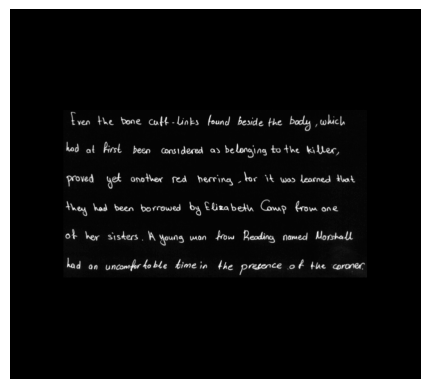

In [4]:
def show(y):
    y = y.detach().cpu()  # bring back from accelerator if it's being used
    return "".join(np.array(iam_paragraphs.mapping)[y]).replace("<P>", "")

idx = random.randint(0, len(x))

print(show(y[idx]))
plt.imshow(x[idx].view(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='Greys_r')
plt.axis("off");

### ResNet Transformer

In [5]:
rnt = text_recognizer.models.ResnetTransformer(data_config=iam_paragraphs.config())

In [6]:
# Cast to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

rnt.to(device); x = x.to(device); y = y.to(device);

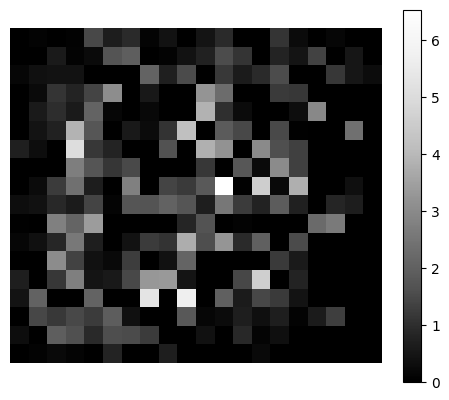

In [24]:
# Pass single input through encoder

# ResNet is designed for RGB images, replicate the input across channels 3 times
resnet_embedding, = rnt.resnet(x[idx:idx+1].repeat(1, 3, 1, 1))

resnet_idx = random.randint(0, len(resnet_embedding))  # re-execute to view a different channel
plt.matshow(resnet_embedding[resnet_idx].detach().cpu(), cmap="Greys_r");
plt.axis("off"); plt.colorbar(fraction=0.05);

In [27]:
preds, = rnt(x[idx:idx+1])

<S>d/ddNGddYrdaddVdVdVENdNVdVdddddhhddNrdVddddhdddNdddNdddVdYdVNdNVFVdVddVddNVddNdF/ddGdddddEdYYddNYddGddddFadVdbdddddddNdahdddddd?dNNVdFdNNd?dddaadhddddddhdhdVddE#dVdddddNVdhdYrVdNddNgddNdVYdhddddEdVddVVddVddddNGddNddddddddd/dVddNddddddVFdVddVddddNdgVdVddddaVVddddNNNVddaVhddddNdddVddVdNVdrddEYdVdddVdddddbddrdVddaFFdVddddVdddVdrddddddVdddardhddddNdddVrdNEhVddhrdZdVNdddVVhddddddddNddddhNdVddrhdNdEddhdddrdddNddVrVddddVdddVddddNVdddddddddddrdddddrdddhhddddVNdNddddGddddddd//rGddVddNddErhGYFFdNaEFddddrddhYdF3NdhV+dddEdddddVhddddhhddddddgddVdddrrVhddNdadNddddddN/dddNGddaNNdEdrbdVdNNddddddddhdddVNdFdNdhNddVd4ddddVddNdddddEdEdVFddVraVddGVdddFdddVFdNdVVErddddNVdddddGFVVhNNNddYdddddddd


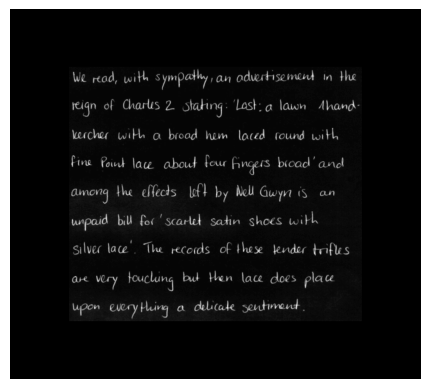

In [32]:
# Prediction from untrained model
print(show(preds.cpu()))
plt.imshow(x[idx].view(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='Greys_r')
plt.axis("off");

### TransformerLitModel

In [7]:
import text_recognizer.lit_models

lit_rnt = text_recognizer.lit_models.TransformerLitModel(rnt)

In [8]:
forcing_outs, = lit_rnt.teacher_forward(x[idx:idx+1], y[idx:idx+1])

b5?F4?DF4??4?CxV??Vb??44C?V4?V?x?4?VV???????:44???C44w??4?4?;???4C?x44?bV4bb?4444CCF???4?C?b?4?4C??44?F???4b4??4F;;FVb?VC4??bV4???F?TTVUV???;F?VMF???4V??C??4F?V?4?xb?FF?4?CbC????4VCF???4U?44??FF??b44?b???FVC444?4?V??V?V7Vb7V:4?V4bx4V4;?4?4b?4;?Fb4?4?V?x?b4?4bF?C4?F?x?????x?bbbF??C???4FF??????V4F??VCbWV?CbF7UC??b?FV?C?4C?b???b?4?V??44?4?VUbWCC4?7?44CTx?xbVV44?bV??444FV?x?4F?x;??444x4?4?CC?4?444xx4?7?xF4;V??bC4Cx???FV??x?b??xV?T44?4V4?bb???xb;C444;??444?????V?4b????W4?xb?C?U?V?FF4?F?b4??CC4???4b????bbd?4FV??F????4?x???F4?U4??4:44?C?x44CWb??CFF???CC???FC4??V4?;??;C4???4C?F4???C?;4??CV?4?xxdVF??bCx?44W4x4?44????V?4F444???4????4V???4??744?F4?4;?bF4???4b4??4F4FF4D4bb?F4?bVb4b?444


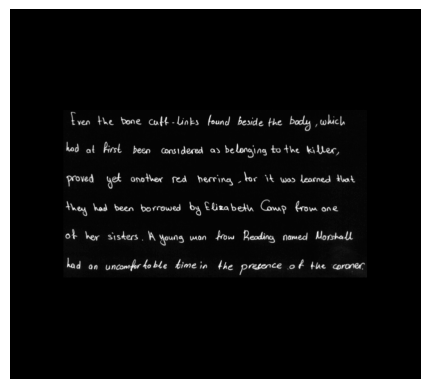

In [9]:
forcing_preds = torch.argmax(forcing_outs, dim=0)

print(show(forcing_preds.cpu()))
plt.imshow(x[idx].view(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='Greys_r')
plt.axis("off");

In [10]:
%run ../training/run_experiment.py --data_class IAMParagraphs --model_class ResnetTransformer --loss transformer \
  --batch_size 16 --precision 16 \
  --limit_train_batches 10 --limit_test_batches 1 --limit_val_batches 2

AttributeError: module 'torch.nn.functional' has no attribute 'transformer'